# 本程序用于分析往届《结构力学（2）》的成绩

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt


path = "./"
files = os.listdir(path)

定义读入文件生成 DataFrame 的函数

In [2]:
def readFile(fileName):
    return pd.read_csv(fileName, sep="\t")

In [3]:
semesterNumber = str(input(f"请输入学期号码："))
dataFileName = semesterNumber+".txt"
df = readFile(dataFileName)
# 重新生成 index 从 0 开始
df = df.reset_index(drop=True)
len1 = len(df)

In [4]:
# 清洗数据
# 去除”最终成绩“为0的行
df = df[df["最终成绩"] != 0]
len2 = len(df)
print(f"初始数据一共有 {len1} 条，清洗后一共有 {len2} 条数据")
# 将”期末成绩“转换为数值型
df["期末成绩"] = pd.to_numeric(df["期末成绩"])


初始数据一共有 87 条，清洗后一共有 87 条数据


In [5]:
# 本学期考试总人数
print(f"本学期考试有效成绩共 {len2} 条记录")
# 列出平时成绩平均值和标准差，列出总评成绩平均值和标准差，列出最终成绩平均值和标准差
print(f"平时成绩：平均值 = {df["平时成绩"].mean():.2f}, 标准差 = {df["平时成绩"].std():.2f}")
print(f"期末成绩：平均值 = {df["期末成绩"].mean():.2f}, 标准差 = {df["期末成绩"].std():.2f}")
print(f"最终成绩：平均值 = {df["最终成绩"].mean():.2f}, 标准差 = {df["最终成绩"].std():.2f}")

本学期考试有效成绩共 87 条记录
平时成绩：平均值 = 91.92, 标准差 = 13.22
期末成绩：平均值 = 81.87, 标准差 = 14.76
总评成绩：平均值 = 84.99, 标准差 = 13.02


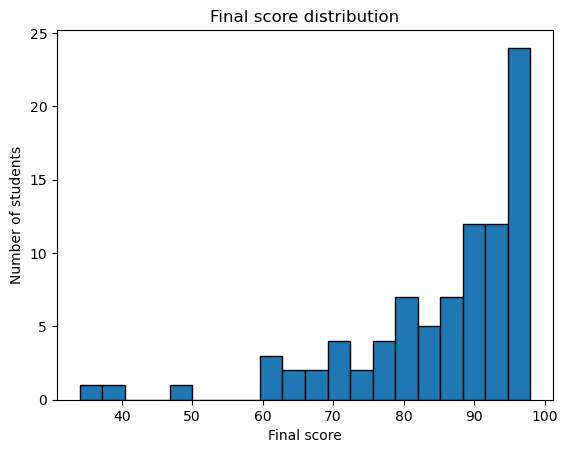

In [8]:
# 绘制最终成绩直方图
plt.hist(df["最终成绩"], bins=20, edgecolor="black")
plt.xlabel("Final score")
plt.ylabel("Number of students")
plt.title("Final score distribution")
plt.show()
